# Demo 01: Open files, and create an overview

## Introduction

This Jupyter Notebook contains a simple introduction to basic concepts of themachinethatgoesping (short: Ping).

## Here you will learn

- how to open files (ping opens many files at once)
- how to access datagrams and pings (and also the concept of what a ping is for themachinethatgoesping)
- how to get an overview of the data by:
    - sorting pings
    - extracting and plotting the navigation data onto a map
    - Extra: if you have a nice geotiff you can also learn how to plot it onto a map

## Short version

At the end of the notebook you will find the important parts of this notebook, compiled into a single cell


## ---

### First: Import the necessary modules

In [1]:
# use widgets as matplotlib backend
%matplotlib widget

# imports
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
from collections import defaultdict
from time import time
from tqdm.auto import tqdm #progress bar, auto selects a backend based on the environment e.g. for a jupyter notebook it will use the widget version

from typing import Union, Tuple

import matplotlib as mpl

# import the file object for opening kongsberg files
# Note: function and library naming to be discussed
from themachinethatgoesping.echosounders import em3000          # This is the filereader module for .all/.wcd files
from themachinethatgoesping.echosounders import index_functions # This is the module for creating and using indexes to speed up file initialization
import themachinethatgoesping.tools as ptools                   # Some tools for working with ping (here we use timeconv for timestamp conversion)

# simplify creating figures
mpl.rcParams['figure.dpi'] = 100
close_plots: bool = True

def create_figure(name: str, return_ax: bool = True) -> Union[Tuple[plt.Figure, plt.Axes], plt.Figure]:
    """Helper function to create a figure with a given name that returns the figure and axis
    """
    if close_plots:
        plt.close(name)
    fig = plt.figure(name)
    fig.suptitle = name

    if return_ax:
        return fig, fig.subplots()
    return fig

### Find files to open

This is a simple python loop to find .all and .wcd files in the specified directories

In [2]:
# Define the folder(s) to search for Kongsberg files
# Note: subdirectories will be searched as well
folders = []
folders.append("/home/users/data/2023_8_TURBEAMS/")

# Initialize lists for storing file paths and names
files = []

# Loop through each folder and its subfolders to find Kongsberg files
for folder in folders:
    for root, dirs, filenames in os.walk(folder):
        for filename in filenames:
            # Check if the file is a Kongsberg .all/.wcd file
            if filename.endswith('.wcd') or filename.endswith('.all'):
                # Add its full path to the list of files
                filepath = os.path.join(root, filename)
                files.append(filepath)

# Print the number of files found
print("Number of Kongsberg files found:", len(files))

# Uncomment the following lines to print the full paths of the found files
# for f in files:
#     print(f)

Number of Kongsberg files found: 289


## Open files

We will use the `FileEM3000_mapped` function to index all the specified files and provide access to them as a combined file stream. Ping is built around opening multiple files at once, so that they can be treated as a single file stream. If a `.all` and a `.wcd` file with the same name (one `.all` and one `.wcd`) are added, they will be matched to a single file.

You do not need to worry about sorting the files in time or anything like that. Instead, we will sort the pings of these files later.

## What happens when calling em3000.FileEM3000_mapped(files)

1. First, an index is created for all files. This means that the position, type, and timestamp of each datagram are saved. For indexing, only the datagram headers are read, so this process is much faster than, for example, copying the files into a new format.
2. Ping then initializes the navigation by reading all navigation datagrams and creating a navigation interpolator. This interpolator allows for fast access to the navigation at any time and also for transforming between different coordinate systems (from antenna to transducer).
3. Finally, the datagrams in the files that belong to the same ping number are sorted to the ping object that will then use these datagrams to provide high and low-level data access to the user.

## What is cached_index

- We will first try to load an existing index file, to speed up the file opening process.
- If it does not exist it will be created from the em3000.FileEM3000_mapped object after first initialization. (Third cell from here)
- If it does exist, it will speed up the file opening process when initializing the em3000.FileEM3000_mapped object.

In [3]:
# This code creates a folder called 'index', where an index file for each folder where a .all or .wcd file was found is stored.
# The index files are created later. If you previously run this notebook already, 
# the cached_index will speed up the initialization of FileEM3000 (next cell)

cached_index = index_functions.load_index_files(file_paths=files)

In [4]:
# Finally, we tell Ping to index all these files
# Note (1): em3000 is the .all/.wcd file reader module
# Note (2): If the cached_index already exists (i.e., it is not an empty dictionary), you will notice a significant speedup
# Note (3): fm is the object that will contain the functions to access the data
# Note (4): em3000.FileEM3000_mapped uses memory mapping internally. This is faster than the default FileEM3000 which is based on iostreams. 
#           However, it requires more memory. If you run into memory issues, try using FileEM3000 instead.

fm = em3000.FileEM3000_mapped(files, cached_index=cached_index)

# If you encounter warnings or errors, contact me (peter.urban@ugent.be) or create an issue on GitHub.


indexing files ⠁ 99% :00s<00m:00s] [Found: 5133208 datagrams in 289 files (25574MB)]                                                 
Initializing ping interface ⠁ 99% :06s<00m:00s] [Done]                                              


In [5]:
# save the index of fm to disk for later reuse
# Note(1): At this moment only the datagram index is saved. 
#          This means that the navigation data and the pings still have to be initialized when opening FileEM3000
#          In the future we will save more information to further speed up the file loading process
# Note(2): The index is saved in a folder called index in the current working directory
# Note(3): If you restart the notebook after executing this cell you should notice that FileEM3000 will load much faster

index_functions.update_index_files(fm.get_cached_file_index())

# Working with the fm object()

fm represents all the files that where opened with em3000.FileEM3000_mapped(files). 
Fm provides different data interfaces:

- raw datagram access (datagram_interface)
- configuration access (configuration_interface)
- navigation access (navigation_interface)
- environment parameters access (environment_interface)
- ping access (ping_interface) 

Most of the time, however you will only need the pings created by the ping_interface. 
This you can access with: fm.pings()

In [6]:
# First, let's print some information about the files we just opened
# This will give us an overview of:
# - the number of files and their total size
# - the datagrams and datagram types in the files
# - the number of detected pings sorted by channel_id (channel_id is the transducer name)

# fm is the object that contains all the functions to access the data in the files
# We can print it to get an overview of the data in the files
print("Overview of the data in the files:")
print(fm)  # fm is the object that contains all the functions to access the data in the files


Overview of the data in the files:
FileEM3000
##########
-
File infos 
-------------               
- Number of loaded .all files: : 145      
- Number of loaded .wcd files: : 144      
- Total file size: :             24.97 GB 

 Detected datagrams 
^^^^^^^^^^^^^^^^^^^^ 
- timestamp_first:  19/04/2023 18:36:51.89 
- Total:            5133208                
- Datagrams [0x30]: 166                    [PUIDOutput]
- Datagrams [0x31]: 127464                 [PUStatusOutput]
- Datagrams [0x41]: 505688                 [AttitudeDatagram]
- Datagrams [0x43]: 127765                 [ClockDatagram]
- Datagrams [0x47]: 2555                   [SurfaceSoundSpeedDatagram]
- Datagrams [0x49]: 311                    [InstallationParametersStart]
- Datagrams [0x4e]: 210627                 [RawRangeAndAngle]
- Datagrams [0x50]: 510887                 [PositionDatagram]
- Datagrams [0x52]: 105535                 [RuntimeParameters]
- Datagrams [0x55]: 341                    [SoundSpeedProfileDatagram]


## themachinethatgoesping revolves around pings

This will be your main access point, so all this raw datagram access and interfaces will be explained later.

### What is a ping?

A ping is a single sonar transmission. It is the basic unit of data in themachinethatgoesping.
A ping object holds some cached data, such as timestamp geolocation and sonar settings, but it also provides access to the raw datagrams that belong to this ping.

You can copy pings as much as you like because a ping is only a reference. Copying and sorting pings in new lists does thus not take up much memory.
Pings also contain pointers to the datagrams that belong to them. These datagrams will only be read when you access them or call functions that require them.

### How to access pings

Call fm.pings() to get a list of all pings. This list is sorted by time.

pings = fm.pings() will create PingContainer that contains all pings of all loaded files.

### What is a PingContainer

A PingContainer is a list of pings. It acts like a list and supports the same functions. You can thus iterate over it, sort it, slice etc.

Access the 10th ping by calling pings[10]

Additionally, a PingContainer provides some additional functions to sort and select pings.

e.g.:

- pings.sort_by_time() will sort the pings by time
- pings.break_at_time(t) will split the PingContainer into PingContainers when the time difference between two pings is larger than t

You can also sort pings into default python lists. However, the extra functions provided by PingContainer are not available then


In [7]:
# Create a object that holds all pings
# We access the pings sorted by time
pings = fm.pings().get_sorted_by_time()

#Get an overview of the ping container (e.g. time of first and last ping, number of pings, number of pings per channel)
print(pings)

PingContainer
#############
-
Time info 
------------            
- Start time: 19/04/2023 18:37:18.37 
- End time:   22/04/2023 05:17:33.15 
- Sorted:     ascending              

 Contained pings 
----------------- 
- Total:    210813 
- TRX-2004: 105409 
- TRX-2031: 105404 


In [8]:
# Print the first ping in the pings list
# TODO: This function currently prints too much unimportant information
print(pings[0])

EM3000Ping
##########
-
Ping infos 
-------------                                                             
- Source file: /home/users/data/2023_8_TURBEAMS/em2040/0000_20230419_183719_Belgica.all [77]
- Channel id:  TRX-2004                                                                 
- Time info:   19/04/2023 18:37:18.37                                                   [1681929438.366000]
- -Features:   watercolumn, bottom                                                      
- -Features:   xyz, two_way_travel_times, beam_crosstrack_angles                        
- -Features:   bottom_range_sample, amplitudes                                          

 Geolocation 
------------- 
- latitude:  51°24'15.0"N  [ddd°mm',ss.s''N/S]
- longitude: 2°48'35.6"E   [ddd°mm',ss.s''E/W]
- z:         3.72          [positive downwards, m]
- yaw:       236.58        [90 ° at east]
- pitch:     -2.40         [° positive bow up]
- roll:      34.52         [° positive port up]

 Sensor data 
-----

In [9]:
# pings is a PingContainer object that acts like a list of pings, but also contains some extra functionss
# You can access individual pings by iterating, indexing and also slices are available to select multiple pings
# Note : pings do not hold much data, think of them as references to the data in the file
#        Furthermore: each ping that you see here is actually a reference to a ping in memory
#        Thus: Copying pings and sorting them into new lists is very cheap and you can create as many ping lists as you like

# Select the 100th ping from the pings list
p = pings[100]

# Print the information about the selected ping
# TODO: This function currently prints too much unimportant information
print(p)

EM3000Ping
##########
-
Ping infos 
-------------                                                             
- Source file: /home/users/data/2023_8_TURBEAMS/em2040/0000_20230419_183719_Belgica.all [77]
- Channel id:  TRX-2031                                                                 
- Time info:   19/04/2023 18:38:18.97                                                   [1681929498.967000]
- -Features:   watercolumn, bottom                                                      
- -Features:   xyz, two_way_travel_times, beam_crosstrack_angles                        
- -Features:   bottom_range_sample, amplitudes                                          

 Geolocation 
------------- 
- latitude:  51°24'14.1"N  [ddd°mm',ss.s''N/S]
- longitude: 2°48'34.4"E   [ddd°mm',ss.s''E/W]
- z:         4.57          [positive downwards, m]
- yaw:       207.28        [90 ° at east]
- pitch:     -1.75         [° positive bow up]
- roll:      -35.40        [° positive port up]

 Sensor data 
-----

## Working with ping containers--

In [10]:
# Now we access the pings sorted by time
# This is important, because the list of files you provided is not necessarily sorted by time
# TODO: sorting by time should be default behavior
pings = fm.pings().get_sorted_by_time()

# Loop through every ping and get the timestamp
# Note(1): tqdm is a progress bar
# Note(2): This loop is fast because no data is read.
#          The timestamp was read and cached when initializing FileEM3000
t = []
for p in tqdm(pings):
    t.append(p.get_timestamp())

# Calculate the mean timestamp of all pings
mean_t = np.mean(t)

# Print the mean timestamp and the mean date/time of each ping
# We use the ptool.timeconv module to convert the timestamp to a date/time string
print("Mean timestamp of each ping:", mean_t)
print("Mean date/time of each ping:", ptools.timeconv.unixtime_to_datestring(mean_t, format="%d-%m-%Y %H:%M:%S"))


  0%|          | 0/210813 [00:00<?, ?it/s]

Mean timestamp of each ping: 1682045270.8277454
Mean date/time of each ping: 21-04-2023 02:47:51


### Create a simple navigation plot

  0%|          | 0/105407 [00:00<?, ?it/s]

Hopefully you see a nice quick plot of the navigation data. 
However this does not yet give a good overview if you loaded many files from different surveys.


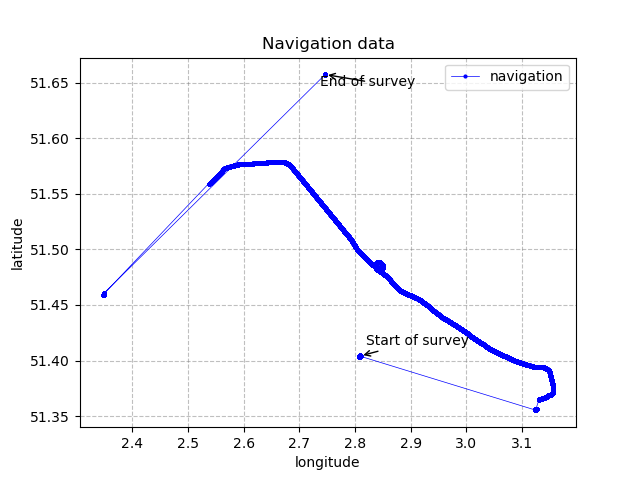

In [11]:
# Let's plot the navigation of your file (naive approach)

# First, we downsample the pings to not plot more than 100000 points. 
# This is done to avoid slowing down Matplotlib when plotting too many points.
# Note that creating new ping lists barely costs memory because pings are just references.
# So, the list creation would also be fast if we did not downsample.
if len(pings) > 100000:
    plot_pings = pings[::int(len(pings)//100000)]
else:
    plot_pings = pings

# plot_pings is now a Python list that contains a subset of the pings.
# Let's iterate over this list and get the navigation data.

# Create empty lists to store the latitude and longitude data
lat = []
lon = []

# Iterate over the downsampled pings and get the geolocation data
for p in tqdm(plot_pings):
    # Each ping has a function called get_geolocation.
    # This function returns a Geolocation object holding the latitude and longitude of the transducer at the time of the ping,
    # as well as the attitude data (pitch, roll, heave, heading).
    # The geolocation was created and cached during the initialization of FileEM3000 above.
    # This loop will thus also run fast.
    g = p.get_geolocation()
    lat.append(g.latitude)
    lon.append(g.longitude)

# Create a figure and plot the navigation data.
fig, ax = create_figure("navigation")
ax.grid(True, linestyle='--', color='gray', alpha=0.5)
ax.plot(lon, lat, label="navigation", color='blue', linewidth=0.5, marker='o', markersize=2, markevery=1)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_title("Navigation data")
#ax.set_aspect('equal')
ax.legend()

# Add arrows with labels that indicate the beginning and the end of the survey
ax.annotate('Start of survey', xy=(lon[0], lat[0]), xytext=(lon[0]+0.01, lat[0]+0.01),
            arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=10)
ax.annotate('End of survey', xy=(lon[-1], lat[-1]), xytext=(lon[-1]-0.01, lat[-1]-0.01),
            arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=10)

# Add text to the right of the plot to explain what the plot shows
print("Hopefully you see a nice quick plot of the navigation data. \nHowever this does not yet give a good overview if you loaded many files from different surveys.")


## Create a better overview by splitting the pings into surveys


In [12]:
# To get a better overview of the data when loading multiple surveys, we need to order the pings into surveys and plot the navigation of each survey.

# First, we split the pings into containers depending on the time aspect.
# Here, we use a time difference of 15 minutes to define the boundaries of each container.
ping_containers = fm.pings().get_sorted_by_time().split_by_time_diff(15 * 60)

# Next, we print some information about the ping containers.
# This will help us verify that the containers have been created correctly.
print("If you only see one container, then your files do not contain gaps between pings larger than 15 minutes.")
for i, p in enumerate(ping_containers):
    print("Ping container number {} contains {} pings.".format(i, len(p)))


If you only see one container, then your files do not contain gaps between pings larger than 15 minutes.
Ping container number 0 contains 43583 pings.
Ping container number 1 contains 75296 pings.
Ping container number 2 contains 54658 pings.
Ping container number 3 contains 37138 pings.
Ping container number 4 contains 138 pings.


In [13]:
# Let's get the navigation data for each ping in each container.

# First, we get the total number of pings in all the ping containers.
total = np.sum([len(p) for p in ping_containers])

# Create a progress bar to track the progress of the loop.
prg = tqdm(total=total, desc="Get navigation from pings")

# Create a dictionary to store the navigation data.
# We use a defaultdict, which automatically creates a new list if you try to access a key that does not exist.
nav_locations = defaultdict(list)

# Loop over each ping container and each ping in the container.
for i, pings in enumerate(ping_containers):
    # Update the progress bar description to show the current ping container index.
    prg.set_description("ping_container nr {}".format(i))

    for p in pings:
        # Get the geolocation data for the current ping and append it to the list for the current ping container index.
        g = p.get_geolocation()
        nav_locations[i].append([g.latitude,g.longitude])

        # Update the progress bar to show the progress of the loop.
        prg.update(1)


Get navigation from pings:   0%|          | 0/210813 [00:00<?, ?it/s]

### Create interactive map using ipyleaflet

In [14]:
# Import necessary libraries
from ipyleaflet import Map, basemaps, basemap_to_tiles, AntPath, projections, Marker, AwesomeIcon
from ipywidgets import Layout, HTML
from matplotlib import colormaps,colors

# Create a colormap for the different surveys
cmap = colormaps.get_cmap("tab20")

# Create a map
m = Map(
    basemap=basemap_to_tiles(basemaps.Esri.NatGeoWorldMap),  # Set the basemap to Esri NatGeoWorldMap
    center=(np.nanmedian(lat), np.nanmedian(lon)),  # Set the center of the map to the median latitude and longitude of the navigation data
    layout=Layout(width='80%', height='600px'),  # Set the layout of the map
    zoom=9,  # Set the zoom level of the map
    crs=projections.EPSG3857  # Set the coordinate reference system of the map
)

# For each survey create an AntPath
for k,n in nav_locations.items():

    # Create an AntPath object with the navigation data and a color based on the survey index
    ant_path = AntPath(
        locations=n,
        color=colors.to_hex(cmap(k))
    )

    # Add the AntPath to the map
    m.add(ant_path)

    # Create a marker for the first location of the survey
    icon = AwesomeIcon(
        name='ship',
        marker_color="white",
        icon_color=colors.to_hex(cmap(k)),
        #spin=True
        )
    marker = Marker(
        location = n[0],
        icon=icon,
        title=str(k)
    )
    message = HTML()
    message.value = str(k)
    marker.popup = message

    # Add the marker to the map
    m.add(marker)

# Display the map
m

Map(center=[51.40335584871131, 2.853563368533637], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [15]:
# This code adds a background map to the existing map created in cell 19.
# If you have a geotiff file for the background map, you can specify its path in the variable 'background_map_path'.
# Note that the localtileserver module is used to tile the geotiff file, so you can add a large tiff without worrying about performance.
# If 'background_map_path' is not specified, the map will not have a background.

import warnings

background_map_path = "/home/ssd/src/themachinethatgoesping/tutorials/test_data/map/210412_BELGIUM_BCP_DTM_20m_LAT.tiff"

if background_map_path:
    if os.path.exists(background_map_path):
        # Import necessary libraries
        from localtileserver import get_leaflet_tile_layer, TileClient

        # Create a TileClient object with the geotiff file path
        client = TileClient(background_map_path)

        # Get a leaflet tile layer from the TileClient object
        t = get_leaflet_tile_layer(client, band=1, cmap="YlGnBu_r")

        # Add the leaflet tile layer to the map
        m.add_layer(t)
    else:
        # Print a warning message in orange color
        warning_message = "The specified background map ({}) path does not exist.".format(background_map_path)
        warnings.warn("\033[33m{}\033[0m".format(warning_message), UserWarning)


/ssd/opt/miniforge3/envs/dev/lib/python3.11/site-packages/large_image/tilesource/utilities.py:206: RuntimeWarning: invalid value encountered in cast
  image = image.astype(np.uint8)


# Conclusion

That's it for this tutorial. Here is what you have learned:

- Open files using the em3000.FileEM3000_mapped function, remember that this class takes a list of many files at once
- em3000.FileEM3000_mapped indexes the provided files, this process can be speed up by using an previously created index file
- Ping revolves around pings and the main function to access them is fm.pings()
- These pings can be sorted into new list and copied as much as you like. This allows for sorting and selecting pings before doing expensive data processing
- Pings are the basic unit of data in themachinethatgoesping. They contain cached data and provide access to the raw datagrams that belong to them.
- Datagrams are only read completely if the datagram is loaded into memory, or if a function is called that requires the datagram data.
- Pings provide high level functions to the user. E.g. get_geolocation which provides the interpolated and transformed geolocation of the pings transducer at ping time. To speed these functions up, some data is internally cached in the ping object.
- Additionally, we showed you how sorting and selecting pings can be used to create a overview of the data by plotting the navigation data onto an interactive map.

Now it is time to play around. Stay tuned for the next tutorial where we will actually access data and do something with that

# Here is a short version of the above code

In [16]:
import os
import warnings
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm.auto import tqdm

from themachinethatgoesping.echosounders import em3000          # This is the filereader module for .all/.wcd files
from themachinethatgoesping.echosounders import index_functions # This is the module for creating and using indexes to speed up file initialization

from ipyleaflet import Map, basemaps, basemap_to_tiles, AntPath, projections, Marker, AwesomeIcon
from ipywidgets import Layout, HTML
from matplotlib import colormaps,colors
from localtileserver import get_leaflet_tile_layer, TileClient

# -- load files from folders -- 
folders = []
folders.append("/home/users/data/2023_8_TURBEAMS/")

# Initialize lists for storing file paths and names
files = []

# Loop through each folder and its subfolders to find Kongsberg files
for folder in folders:
    for root, dirs, filenames in os.walk(folder):
        for filename in filenames:
            # Check if the file is a Kongsberg file
            if filename.endswith('.wcd') or filename.endswith('.all'):
                # If the file is a Kongsberg file, add its full path to the list of files
                filepath = os.path.join(root, filename)
                files.append(filepath)


# -- load index files (if they exist) --
cached_index = index_functions.load_index_files(file_paths=files)


# -- initialize FileEM3000 --
fm = em3000.FileEM3000_mapped(files, cached_index=cached_index)


# -- save index files to disk --
index_functions.update_index_files(fm.get_cached_file_index())


# -- split pings into containers depending on the time aspect --
ping_containers = fm.pings().get_sorted_by_time().split_by_time_diff(15 * 60)


# -- get navigation data for each ping in each container --
print()
total = np.sum([len(p) for p in ping_containers])
prg = tqdm(total=total, desc="Get navigation from pings")
nav_locations = defaultdict(list)
lat = [] # this list is created to get a median location for the map
lon = [] # this list is created to get a median location for the map
for i, pings in enumerate(ping_containers):
    prg.set_description("Get navigation from ping_container {}".format(i))
    for p in pings:
        g = p.get_geolocation()
        nav_locations[i].append([g.latitude,g.longitude])
        lat.append(g.latitude)
        lon.append(g.longitude)
        prg.update(1)


# -- create an interactive  map for the navigation data --
# Create a colormap for the different surveys
cmap = colormaps.get_cmap("tab20")

# Create a map
m = Map(
    basemap=basemap_to_tiles(basemaps.Esri.NatGeoWorldMap),  # Set the basemap to Esri NatGeoWorldMap
    center=(np.nanmedian(lat), np.nanmedian(lon)),  # Set the center of the map to the median latitude and longitude of the navigation data
    layout=Layout(width='80%', height='600px'),  # Set the layout of the map
    zoom=9,  # Set the zoom level of the map
    crs=projections.EPSG3857  # Set the coordinate reference system of the map
)

# For each survey create an AntPath
for k,n in nav_locations.items():

    # Create an AntPath object with the navigation data and a color based on the survey indexping related
    ant_path = AntPath(
        locations=n,
        color=colors.to_hex(cmap(k))
    )

    # Add the AntPath to the map
    m.add(ant_path)

    # Create a marker for the first location of the survey
    icon = AwesomeIcon(
        name='ship',
        marker_color="white",
        icon_color=colors.to_hex(cmap(k)),
        #spin=True
        )
    marker = Marker(
        location = n[0],
        icon=icon,
        title=str(k)
    )
    message = HTML()
    message.value = str(k)
    marker.popup = message

    # Add the marker to the mapbackground_map_path
    m.add(marker)


# -- add a background map to the existing map --
background_map_path = "/home/ssd/src/themachinethatgoesping/tutorials/test_data/map/210412_BELGIUM_BCP_DTM_20m_LAT.tiff"

if background_map_path:
    if os.path.exists(background_map_path):
        # Import necessary libraries
        from localtileserver import get_leaflet_tile_layer, TileClient

        # Create a TileClient object with the geotiff file path
        client = TileClient(background_map_path)

        # Get a leaflet tile layer from the TileClient object
        t = get_leaflet_tile_layer(client, band=1, cmap="YlGnBu_r")

        # Add the leaflet tile layer to the map
        m.add_layer(t)
    else:
        # Print a warning message in orange color
        warning_message = "The specified background map ({}) path does not exist. Please edit 'background_map_path'".format(background_map_path)
        warnings.warn("\033[33m{}\033[0m".format(warning_message), UserWarning)


#-- Display the map --
m


indexing files ⠁ 99% :01s<00m:00s] [Found: 5133208 datagrams in 289 files (25574MB)]                                                 
Initializing ping interface ⡀ 99% :06s<00m:00s] [Done]                                              



Get navigation from pings:   0%|          | 0/210813 [00:00<?, ?it/s]

Map(center=[51.403356415895544, 2.8535864722888413], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [17]:
# Notice how the majority of the above code is not related to ping, 
# but to opening files and creating a nice a beautiful map using ipyleaflet.